# 05: Jaynes-Cummings Ultra-strong Coupling

In this tutorial we will look at what happens when the coupling between the atom and the cavity becomes very strong. We will introduce a new model for the dissipation that more accurately describes the time evolution and compare with the standard Jaynes-Cummings dissipation model.

## Introduction

If the coupling strength becomes so large that it is comparable to the system frequencies, the collapse operators from the previous tutorial do not correctly model the dissipation (for instance it does not give the ground state as the steady state at zero temperature). This is because the eigenenergies of the system are significantly altered by the coupling between the atom and the cavity.

We need to rederive the master equation, defining the system-environment coupling operator in terms of the true system eigenstates, in do so we arrive at a master equation of this form


$$\frac{\partial}{\partial t} \rho_S(t) = -i[H_S,\rho(t)] \\
+ \sum_{\Gamma=\gamma,\kappa}\left(\sum_{j,k>j}\Gamma_{j,k}n(\Delta_{j,k},T) \mathcal{D}\left[|k\rangle\langle j|\right] \rho(t) \right.\\
\left. + \sum_{j,k>j}\Gamma_{j,k}\left[1+n(\Delta_{j,k},T)\right] \mathcal{D}\left[|j\rangle\langle k|\right] \rho(t)\right)$$

Where 

$\gamma_{j,k}= \pi J(\Delta_{j,k}) |\langle j|\sigma_x | k \rangle |^2$, 

$\kappa_{j,k}= \pi J(\Delta_{j,k}) |\langle j|(a+a^{\dagger}) | k \rangle |^2$,

$\mathcal{D}\left[|j\rangle\langle k|\right]\rho(t)=2|j\rangle\langle k| \rho |k\rangle\langle j| - |k\rangle\langle k|\rho - \rho |k\rangle\langle k|$, 

$\Delta_{j,k} = E_j - E_k$.

We refer this as the ultra-strong coupling (USC) master equation

We can think of this as the collapse operators coupling to all the different possible energy jumps of the combined atom-cavity system. Note that in practice, some energy states are never occupied and so we can in fact ignore these collapse operators, as we will see later.

## Tasks

Constructing the model described above is quite involved, and so that has been completed already. Our tasks will focus on analysing the output.  

- Try different values for the coupling strength ($0.01 < g < 0.9$) and observe how the eigenenergies change

## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import qutip
import numpy as np

## Helper functions

In [3]:
def jcm_h(wc, wa, g, N, atom):
    """ Construct the Jaynes-Cummings Hamiltonian (non-RWA). """
    a = qutip.tensor(qutip.destroy(N), qutip.qeye(2))
    sm = qutip.tensor(qutip.qeye(N), qutip.destroy(2))
    atom = qutip.tensor(qutip.qeye(N), atom)
    
    H = wc * a.dag() * a + wa * atom + g * (a.dag() + a) * (sm + sm.dag())
    return H

In [4]:
def display_eigenstates(op):
    """ Display the eigenvalues and eigenstates of an operator. """
    evals, evecs = op.eigenstates()
    print("Eigenvalues:", evals)
    print()
    print("Eigenstates")
    print("===========")
    for v in evecs:
        display(v)

## Create the JCM Hamiltonian and USC collapse operators.

In [5]:
def jcm_c_ops(N, n_th_a):
    """ Return basic JCM collapse operators. """
    c_ops = []

    sm = qutip.tensor(qutip.qeye(N), qutip.sigmam())
    a = qutip.tensor(qutip.destroy(N), qutip.qeye(2))

    # cavity relaxation
    rate = kappa * (1 + n_th_a)
    if rate > 0.0:
        c_ops.append(np.sqrt(rate) * a)

    # cavity excitation, if temperature > 0
    rate = kappa * n_th_a
    if rate > 0.0:
        c_ops.append(np.sqrt(rate) * a.dag())

    # qubit relaxation
    rate = gamma
    if rate > 0.0:
        c_ops.append(np.sqrt(rate) * sm)
        
    return c_ops

In [6]:
def matrix_element(a, x, b):
    """ Return <a|x|b>. """
    return (a * x * b).norm()

In [7]:
def jcm_c_ops_from_eigenstates(H, N, n_th_a, n_levels=None):
    """ Return full JCM collapse operators. """
    sx = qutip.tensor(qutip.qeye(N), qutip.sigmax())
    a = qutip.tensor(qutip.destroy(N), qutip.qeye(2))
    x = a + a.dag()

    energies, eigenstates = H.eigenstates()
    n_energies = len(energies)
    if n_levels is not None:
        n_energies = min(n_energies, n_levels)

    c_ops = []

    for j in range(n_energies):
        for k in range(j, n_energies):
            rate = matrix_element(eigenstates[j].dag(), x, eigenstates[k])**2 * kappa
            if rate > 0.0:
                c_ops.append(np.sqrt(rate) * eigenstates[j] * eigenstates[k].dag())

            rate = matrix_element(eigenstates[j].dag(), sx, eigenstates[k])**2 * gamma
            if rate > 0.0:
                c_ops.append(np.sqrt(rate) * eigenstates[j] * eigenstates[k].dag())

    return c_ops

In [8]:
def jcm_brmesolve(H, psi0, tlist, kappa, gamma, N, e_ops, options):
    """ Solve the given Jaynes-Cummings model use the Bloch-Redfield solver. """
    sx = qutip.tensor(qutip.qeye(N), qutip.sigmax())
    a = qutip.tensor(qutip.destroy(N), qutip.qeye(2))
    x = a + a.dag()

    cavity_spectrum = "0 if (w <= 0) else {kappa}".format(kappa=kappa)
    atom_spectrum = "0 if (w <= 0) else {gamma}".format(gamma=gamma)
    a_ops = [
        [x, cavity_spectrum],
        [sx, atom_spectrum],
    ]

    result = qutip.brmesolve(H, psi0, tlist, a_ops=a_ops, e_ops=e_ops, options=options)
    return result

In [9]:
# Dissipation parameters
# We use stronger dissipation to show long-term behaviour in shorter times
kappa = 0.2 # cavity dissipation rate
gamma = 0.2 # atom dissipation rate
n_th_a = 0 # avg number of thermal bath excitation

In [10]:
# system parameters
wc = 1.0 #* 2 * np.pi  # cavity frequency
wa = 1.0 #* 2 * np.pi  # atom frequency
N = 8  # 15 # number of cavity fock states
# g = 0.05 * 2 * np.pi  # coupling strength
g = 0.1

# Atom hamiltonian
H_atom = 0.5 * qutip.sigmaz()

In [11]:
g = 0.01
H = jcm_h(wc, wa, g, N, H_atom)

display_eigenstates(H)

Eigenvalues: [-0.50005     0.48995012  0.50994987  1.48580821  1.51409178  2.48263013
  2.51726985  3.47995099  3.51994899  4.47759071  4.52230927  5.47545696
  5.52444308  6.47369407  6.52660598  7.50034999]

Eigenstates


Quantum object: dims = [[8, 2], [1, 1]], shape = (16, 1), type = ket
Qobj data =
[[ 0.00000000e+00]
 [-9.99987499e-01]
 [ 5.00006250e-03]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-3.53562229e-05]
 [ 1.53098850e-07]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-7.65500471e-10]
 [ 2.85288350e-12]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]

Quantum object: dims = [[8, 2], [1, 1]], shape = (16, 1), type = ket
Qobj data =
[[ 7.05336776e-01]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-7.08854818e-01]
 [ 4.98766997e-03]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-4.29806576e-05]
 [ 2.14371369e-07]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-1.19539882e-09]
 [ 4.87212909e-12]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]

Quantum object: dims = [[8, 2], [1, 1]], shape = (16, 1), type = ket
Qobj data =
[[ 7.08872366e-01]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 7.05318964e-01]
 [-5.01267380e-03]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 4.36302734e-05]
 [-2.18702233e-07]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.22566214e-09]
 [-5.01215407e-12]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]

Quantum object: dims = [[8, 2], [1, 1]], shape = (16, 1), type = ket
Qobj data =
[[ 0.00000000e+00]
 [-3.54814447e-03]
 [-7.04593443e-01]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 7.09576104e-01]
 [-6.10241323e-03]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 6.05979101e-05]
 [-3.37567558e-07]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 2.05992212e-09]
 [-9.06196851e-12]
 [ 0.00000000e+00]]

Quantum object: dims = [[8, 2], [1, 1]], shape = (16, 1), type = ket
Qobj data =
[[ 0.00000000e+00]
 [ 3.52314431e-03]
 [ 7.09593599e-01]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 7.04575573e-01]
 [-6.14572451e-03]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 6.18972486e-05]
 [-3.47252559e-07]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 2.13405951e-09]
 [-9.43247131e-12]
 [ 0.00000000e+00]]

Quantum object: dims = [[8, 2], [1, 1]], shape = (16, 1), type = ket
Qobj data =
[[ 2.53295753e-05]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 5.02191793e-03]
 [ 7.04020438e-01]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-7.10127046e-01]
 [ 7.04099252e-03]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-7.80486706e-05]
 [ 4.75902685e-07]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-3.13419026e-09]]

Quantum object: dims = [[8, 2], [1, 1]], shape = (16, 1), type = ket
Qobj data =
[[-2.46799572e-05]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-4.97861336e-03]
 [-7.10144500e-01]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-7.04002523e-01]
 [ 7.10224820e-03]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-8.01032686e-05]
 [ 4.92679109e-07]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-3.27289661e-09]]

Quantum object: dims = [[8, 2], [1, 1]], shape = (16, 1), type = ket
Qobj data =
[[ 0.00000000e+00]
 [ 1.10459421e-07]
 [ 4.39623084e-05]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 6.15480672e-03]
 [ 7.03535595e-01]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-7.10589815e-01]
 [ 7.86694189e-03]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-9.54019164e-05]
 [ 6.27877284e-07]
 [ 0.00000000e+00]]

Quantum object: dims = [[8, 2], [1, 1]], shape = (16, 1), type = ket
Qobj data =
[[ 0.00000000e+00]
 [-1.06128137e-07]
 [-4.26629698e-05]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-6.09356068e-03]
 [-7.10607237e-01]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-7.03517642e-01]
 [ 7.94602799e-03]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-9.83077858e-05]
 [ 6.53504070e-07]
 [ 0.00000000e+00]]

Quantum object: dims = [[8, 2], [1, 1]], shape = (16, 1), type = ket
Qobj data =
[[-5.56751237e-10]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-2.21452855e-07]
 [-6.22850235e-05]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-7.11128976e-03]
 [-7.03107086e-01]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 7.10996242e-01]
 [-8.61287633e-03]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.12675159e-04]]

Quantum object: dims = [[8, 2], [1, 1]], shape = (16, 1), type = ket
Qobj data =
[[ 5.26481006e-10]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 2.11766943e-07]
 [ 6.02304274e-05]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 7.03221616e-03]
 [ 7.11013635e-01]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 7.03089100e-01]
 [-8.70974309e-03]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.16518796e-04]]

Quantum object: dims = [[8, 2], [1, 1]], shape = (16, 1), type = ket
Qobj data =
[[ 0.00000000e+00]
 [ 2.08913045e-12]
 [ 1.24833617e-09]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 3.50914883e-07]
 [ 8.05420577e-05]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 7.95506452e-03]
 [ 7.02719098e-01]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-7.11362184e-01]
 [ 9.29635673e-03]
 [ 0.00000000e+00]]

Quantum object: dims = [[8, 2], [1, 1]], shape = (16, 1), type = ket
Qobj data =
[[ 0.00000000e+00]
 [-1.94904351e-12]
 [-1.17418031e-09]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-3.34136405e-07]
 [-7.76360793e-05]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-7.85820180e-03]
 [-7.11379515e-01]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-7.02701119e-01]
 [ 9.41087746e-03]
 [ 0.00000000e+00]]

Quantum object: dims = [[8, 2], [1, 1]], shape = (16, 1), type = ket
Qobj data =
[[ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-5.14971133e-12]
 [-2.17525235e-09]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-4.99045092e-07]
 [-9.91507423e-05]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-8.75122103e-03]
 [-7.05045450e-01]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 7.09108116e-01]]

Quantum object: dims = [[8, 2], [1, 1]], shape = (16, 1), type = ket
Qobj data =
[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [4.74181119e-12]
 [2.02069544e-09]
 [0.00000000e+00]
 [0.00000000e+00]
 [4.69759734e-07]
 [9.45751177e-05]
 [0.00000000e+00]
 [0.00000000e+00]
 [8.57116624e-03]
 [7.09056325e-01]
 [0.00000000e+00]
 [0.00000000e+00]
 [7.05099747e-01]]

Quantum object: dims = [[8, 2], [1, 1]], shape = (16, 1), type = ket
Qobj data =
[[ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-1.30673851e-11]
 [-4.52691393e-09]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-9.05450688e-07]
 [-1.61982066e-04]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-1.32272682e-02]
 [-9.99912503e-01]
 [ 0.00000000e+00]]

## Solving and visualising the dynamics

The dynamics are solved here for the simple (from JCM 2 tutorial) and the USC dissipation model

Try changing the coupling strength and see how the two models diverge.
Try changing the initial state and see what happens.

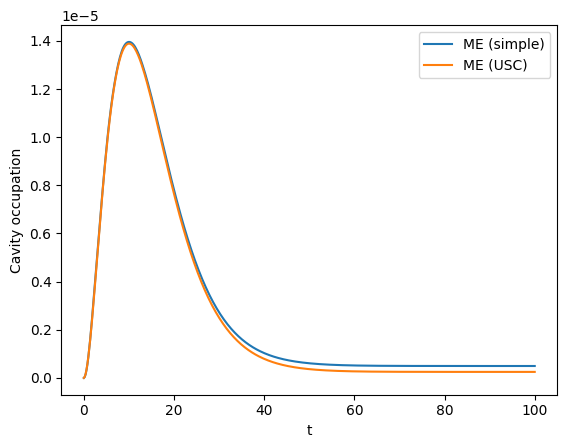

In [12]:
g = 0.001

# get the JCM Hamiltonian
H = jcm_h(wc, wa, g, N, H_atom)

# set the timespace for the simulation
tlist = np.linspace(0, 100, 500)

# get the groundstate for the full system
gnd_energy, gnd_state = H.groundstate()

# set the initial state 
psi0 = qutip.tensor(qutip.basis(N, 0), qutip.basis(2, 0)) # atom excited
# psi0 = qutip.tensor(qutip.basis(N, 0), qutip.basis(2, 1)) # atom ground state
# psi0 = gnd_state

# create the expectation operators
sm = qutip.tensor(qutip.qeye(N), qutip.sigmam())
a = qutip.tensor(qutip.destroy(N), qutip.qeye(2))
e_ops = [a.dag() * a, sm.dag() * sm] # cavity and atom excited state probabilities

# generate the collapse operators
c_ops_simple = jcm_c_ops(N, n_th_a) # basic JCM
c_ops_usc = jcm_c_ops_from_eigenstates(H, N, n_th_a) # USC 

options = qutip.Options(nsteps=15000, store_states=True, rtol=1e-12, atol=1e-12)

result_me_simple = qutip.mesolve(H, psi0, tlist, c_ops=c_ops_simple, e_ops=e_ops, options=options)
result_me_usc = qutip.mesolve(H, psi0, tlist, c_ops=c_ops_usc, e_ops=e_ops, options=options)

# set the timespace for the plot
tlist_plot = np.linspace(0, 100, 500)

plt.plot(tlist_plot, result_me_simple.expect[0], label="ME (simple)")
plt.plot(tlist_plot, result_me_usc.expect[0], label="ME (USC)")
plt.xlabel("t")
plt.ylabel("Cavity occupation")
plt.legend();

## Reduced level couplings (for collapse operators)

Now we investigate how many energy levels we need to consider in order for an accurate model.

You may wish to add a second plot that zooms in on the later times (t > 80) and exclude the simple model plot, to see more clearly how the USC and USC limited level plots converge.

In [13]:
# start by copying the previous cell

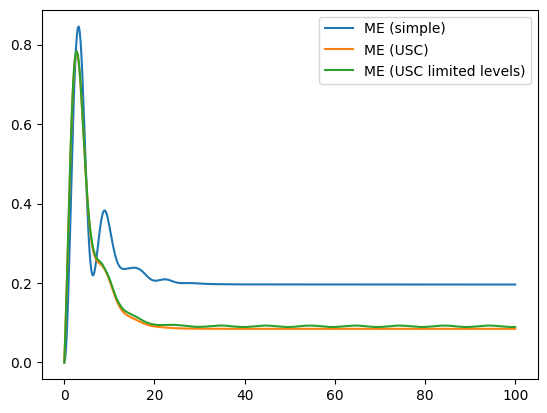

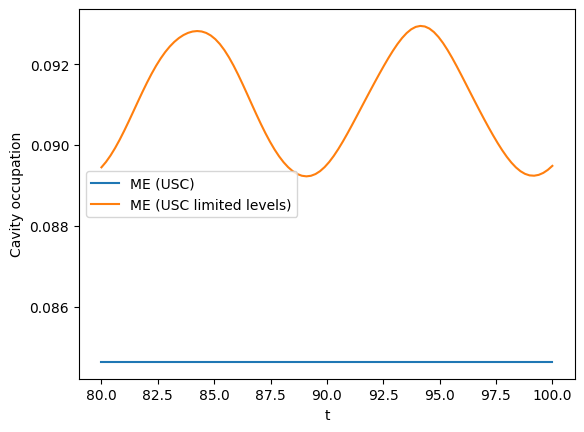

In [14]:
g = 0.5

# get the JCM Hamiltonian
H = jcm_h(wc, wa, g, N, H_atom)

# set the timespace for the simulation
tlist = np.linspace(0, 100, 500)

# get the groundstate for the full system
gnd_energy, gnd_state = H.groundstate()

# set the initial state 
psi0 = qutip.tensor(qutip.basis(N, 0), qutip.basis(2, 0)) # atom excited
# psi0 = qutip.tensor(qutip.basis(N, 0), qutip.basis(2, 1)) # atom ground state
# psi0 = gnd_state

# create the expectation operators
sm = qutip.tensor(qutip.qeye(N), qutip.sigmam())
a = qutip.tensor(qutip.destroy(N), qutip.qeye(2))
e_ops = [a.dag() * a, sm.dag() * sm] # cavity and atom excited state probabilities

# generate the collapse operators
c_ops_simple = jcm_c_ops(N, n_th_a) # basic JCM
c_ops_usc = jcm_c_ops_from_eigenstates(H, N, n_th_a) # USC 
c_ops_usc_levlim = jcm_c_ops_from_eigenstates(H, N, n_th_a, n_levels=5) # USC with level limit

options = qutip.Options(nsteps=15000, store_states=True, rtol=1e-12, atol=1e-12)

result_me_simple = qutip.mesolve(H, psi0, tlist, c_ops=c_ops_simple, e_ops=e_ops, options=options)
result_me_usc = qutip.mesolve(H, psi0, tlist, c_ops=c_ops_usc, e_ops=e_ops, options=options)
result_me_usc_levlim = qutip.mesolve(H, psi0, tlist, c_ops=c_ops_usc_levlim, e_ops=e_ops, options=options)


# set the timespace for the plot
tlist_plot = np.linspace(0, 100, 500)

plt.plot(tlist_plot, result_me_simple.expect[0], label="ME (simple)")
plt.plot(tlist_plot, result_me_usc.expect[0], label="ME (USC)")
plt.plot(tlist_plot, result_me_usc_levlim.expect[0], label="ME (USC limited levels)")
plt.legend();

plt.figure()

tlist_plot = np.linspace(80, 100, 100)
#plt.plot(tlist_plot, result_me_simple.expect[0], label="ME (simple)")
plt.plot(tlist_plot, result_me_usc.expect[0][400:], label="ME (USC)")
plt.plot(tlist_plot, result_me_usc_levlim.expect[0][400:], label="ME (USC limited levels)")

plt.xlabel("t")
plt.ylabel("Cavity occupation")
plt.legend();

## Bloch-Redfield model

Our USC dissipation is actually the Bloch-Redfield model. QuTiP has a solver built in for this.

Simulate the dynamics with the Bloch-Redfield (using the helper function 'jcm_brmesolve')

In [15]:
# start by copying the previous cell

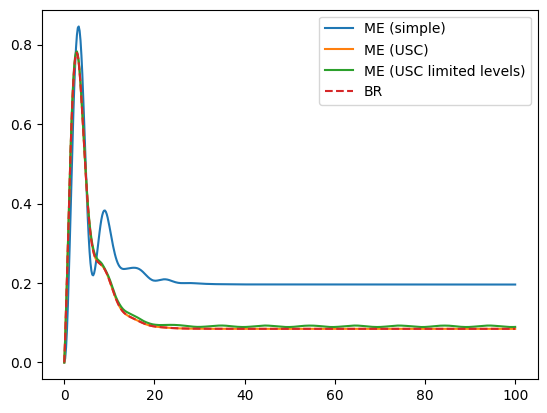

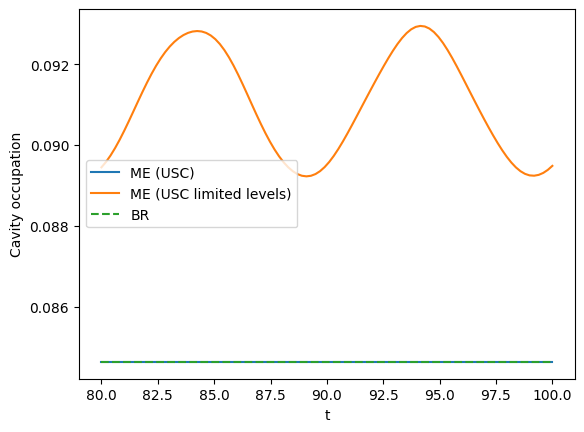

In [16]:
g = 0.5

# get the JCM Hamiltonian
H = jcm_h(wc, wa, g, N, H_atom)

# set the timespace for the simulation
tlist = np.linspace(0, 100, 500)

# get the groundstate for the full system
gnd_energy, gnd_state = H.groundstate()

# set the initial state 
psi0 = qutip.tensor(qutip.basis(N, 0), qutip.basis(2, 0)) # atom excited
# psi0 = qutip.tensor(qutip.basis(N, 0), qutip.basis(2, 1)) # atom ground state
# psi0 = gnd_state

# create the expectation operators
sm = qutip.tensor(qutip.qeye(N), qutip.sigmam())
a = qutip.tensor(qutip.destroy(N), qutip.qeye(2))
e_ops = [a.dag() * a, sm.dag() * sm] # cavity and atom excited state probabilities

# generate the collapse operators
c_ops_simple = jcm_c_ops(N, n_th_a) # basic JCM
c_ops_usc = jcm_c_ops_from_eigenstates(H, N, n_th_a) # USC 
c_ops_usc_levlim = jcm_c_ops_from_eigenstates(H, N, n_th_a, n_levels=5) # USC with level limit

options = qutip.Options(nsteps=15000, store_states=True, rtol=1e-12, atol=1e-12)

result_me_simple = qutip.mesolve(H, psi0, tlist, c_ops=c_ops_simple, e_ops=e_ops, options=options)
result_me_usc = qutip.mesolve(H, psi0, tlist, c_ops=c_ops_usc, e_ops=e_ops, options=options)
result_me_usc_levlim = qutip.mesolve(H, psi0, tlist, c_ops=c_ops_usc_levlim, e_ops=e_ops, options=options)
result_br = jcm_brmesolve(H, psi0, tlist, kappa, gamma, N, e_ops=e_ops, options=options)


# set the timespace for the plot
tlist_plot = np.linspace(0, 100, 500)

plt.plot(tlist_plot, result_me_simple.expect[0], label="ME (simple)")
plt.plot(tlist_plot, result_me_usc.expect[0], label="ME (USC)")
plt.plot(tlist_plot, result_me_usc_levlim.expect[0], label="ME (USC limited levels)")
plt.plot(tlist_plot, result_br.expect[0], "--", label="BR")
plt.legend();

plt.figure()

tlist_plot = np.linspace(80, 100, 100)
#plt.plot(tlist_plot, result_me_simple.expect[0], label="ME (simple)")
plt.plot(tlist_plot, result_me_usc.expect[0][400:], label="ME (USC)")
plt.plot(tlist_plot, result_me_usc_levlim.expect[0][400:], label="ME (USC limited levels)")
plt.plot(tlist_plot, result_br.expect[0][400:], "--", label="BR")

plt.xlabel("t")
plt.ylabel("Cavity occupation")
plt.legend();

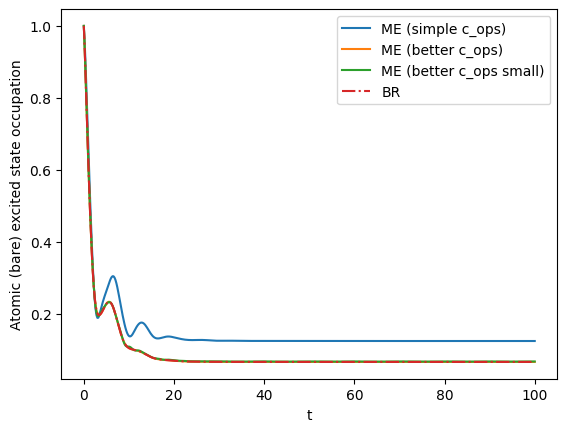

In [17]:
plt.plot(tlist, result_me_simple.expect[1], label="ME (simple c_ops)")
plt.plot(tlist, result_me_usc.expect[1], label="ME (better c_ops)")
plt.plot(tlist, result_me_usc_levlim.expect[1], label="ME (better c_ops small)")
plt.plot(tlist, result_br.expect[1], "-.", label="BR")
plt.xlabel("t")
plt.ylabel("Atomic (bare) excited state occupation")
plt.legend();